# Домашняя работа

В этой работе вам предстоит с помощью encoder-decoder архитектуры, пробуя различные ее реализации, решить задачу машинного перевода.

#### Наша задача - сделать свой собственный переводчик!

Пока что только русско-английский:) Будем учиться на текстах описания отелей, так что при успешном выполнении этого задания у вас не возникнет проблем с выбором места для остановки в путешествии, так как все отзывы вам будут высококлассно переведены!

Что необходимо обсудить до начала работы?

*как токенезовать и закодировать текст?*

С токенезацией хорошо справится WordPunctTokenizer из библиотеки nltk, а вот с кодированием не все так просто, как может показаться...

В наших текстах очень много редких и очень мало встречаемых слов (в каждом отеле есть своя фишка: какой-то предмет декорации или услуга, которая описывается своим словом, которое только там и встречается). Если мы будем кодировать все слова, то размер нашего словаря будет очень-очень большим.

Но на одном из семинаров мы кодировали побуквенно, кажется, что тут это может помочь! Да, действительно так, но придется очень очень долго обучать модель, а путешествовать и выбрать хороший отель уже хочется, поэтому мы придем к чему-то среднему между этими подходами -  [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) известный как __BPE__

Этот алгоритм стартует с посимвольного уровня и итеративно мерджит самые встречаемые пары. И так N итераций. На выходе мы получаем самые частые последовательности символов из которых формируются слова!

In [ ]:
!pip install subword_nmt -q

In [ ]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# разбиваем и токенизируем тексты, записываем обработанные токены в файл
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# строим и применяем bpe кодирование
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:18<00:00, 430.90it/s]


### Построение словарей, разбиение данных

Сейчас, когда мы обучили BPE алгоритм на наших данных, построим словарь соответствия токена и его индекса, чтобы нам было затем удобно смотреть переводы и переводить новые предложения

Также сделаем разбиение на train/test

In [ ]:
import numpy as np

In [ ]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

In [ ]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [ ]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

###  Задание 1 (1 балла)
В коде ниже мы представили шаблон простой encoder-decoder модели, без всяких наворотов с Attention или чем-нибудь еще. Вы можете редактировать его под себя: добавлять новые методы, новые переменные, писать на pytorch ligtning и другое.

Главное - сохраните идею шаблона и сделайте его очень удобным, так как с ним еще предстоит работать!

In [ ]:
!pip install pytorch_lightning -q

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Сначала примените  encode а затем decode"""
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.emb_inp(inp)

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # последние токены, не последние на самом деле, так как мы делали pading, чтобы тексты были одинакового размера
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и
        логиты для следующих токенов
        """
        prev_gru0_state = prev_state[0]

        emb_token = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(emb_token, prev_gru0_state)
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state

        # первый символ всегда BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        # в цикле делаем decode_step, получаем logits_sequence
        for i in range(out_tokens.shape[1] - 1):
            state, output_logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(output_logits)

        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Генерим токены для перевода """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        """Функция для перевода"""
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [ ]:
# debugging area
model = BaseModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [ ]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
vou@@ ķ@@ chiang gda@@ vehicle в queen essen machine umo@@ aka pol provençal auberge premises mich@@ florida bas@@ ok@@ nap@@ е@@ santos short chiang sno
vou@@ ķ@@ chiang basil massages medina linate olive michelin miram@@ west@@ 35 exposed buil@@ pa hal@@ amenities hill pean jardin chicago entirely ital ares born
vou@@ ķ@@ chiang basil massages medina linate olive michelin miram@@ west@@ 35 exposed buil@@ pa hal@@ amenities hill pean jardin chicago entirely ital ares born


### Задание 2 (2 балла)

Тут нечего объяснять, нужно написать лосс, чтобы все училось:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

где $|D|$ это суммарная длина всех предложений включая все токены: BOS, EOS но не включая падинг

In [ ]:
def compute_loss(model, inp, out, **flags):
    """
    Функция для подсчета лосса
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    Для того чтобы пройти тесты, ваша функция должна
    * учитывать в loss первый EOS, но НЕ учиттывать последующие
    * разделить loss на длину вхходящей последовательности (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities всех токенов на всех шагах
    logprobs_seq = torch.log(F.softmax(logits_seq, dim=-1)) # [batch_size, out_len, num_tokens]

    # log-probabilities для верных ответов
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1) # [batch_size, out_len]
    # нужно обойтись только векторными операциями без for

    # cross-entropy по всем токенам где mask == True
    return (-logp_out * mask).sum() / mask.sum() # тут должен получиться скаляр!

In [ ]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1)

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5457, device='cuda:0', grad_fn=<DivBackward0>)


### Метрика: BLEU

Для оценки машинного перевода обычно используется метрика [BLEU](https://en.wikipedia.org/wiki/BLEU). Она просто считает кол-во правильно предсказанных n-grams для n=1,2,3,4 и потом берет геометрическое среднее для полученных значений.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.0018453483836605227

### Training loop (1 балл)

Нужно просто написать цикл обучения и подсчитать метрики! И пройти assert по качеству

In [ ]:
class Dictionary(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
train_set = Dictionary(train_inp, train_out)
test_set = Dictionary(dev_inp, dev_out)

In [ ]:
train_loader = DataLoader(train_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] }

In [ ]:
class Seq2SeqLearner(pl.LightningModule):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        super().__init__()

        self.model = BaseModel(inp_voc, out_voc, emb_size=emb_size, hid_size=hid_size)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def forward(self, inp, out):
        return self.model(inp, out)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        inp, out = train_batch
        inp = inp_voc.to_matrix(inp).to(device)
        out = out_voc.to_matrix(out).to(device)
        loss = compute_loss(self.model, inp, out)
        metrics['train_loss'].append(loss.item())
        return loss

    def validation_step(self, val_batch, batch_idx):
        inp, out = val_batch
        metrics['dev_bleu'].append(compute_bleu(self.model, inp, out))

In [ ]:
torch.cuda.empty_cache()

n_epochs = 10

seq2seq_learner = Seq2SeqLearner(inp_voc, out_voc)

trainer = pl.Trainer(accelerator=device, max_epochs=n_epochs)

trainer.fit(seq2seq_learner, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | model | BaseModel | 2.2 M 
------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.745     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0) > 15, "Ты можешь больше! попробуй еще раз)"

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
vou@@ ķ@@ chiang basil massages medina linate olive michelin miram@@ west@@ 35 exposed buil@@ pa hal@@ amenities hill pean jardin chicago entirely ital ares born ces conserv@@ clo@@ du@@ hal@@ vehicle borrow shi iron medical cen@@ pret@@ palermo sunday refreshments sty@@ st leis@@ guar@@ e jardin ši@@ madison telephone 65 cre@@ elet@@ elet@@ đ@@ đ@@ ces ør@@ ør@@ great aco@@ е@@ ž@@ ł@@ linate drum quiet@@ mrt cru@@ ss ss waterpark pools nei@@ д@@ bei gren mit@@ aran albufeira riva boardwalk turku f riva green inspired es@@ zu slippers accep@@ gher@@ gher@@ hal@@ pe bit@@ arranges siem hydro@@ е@@ fic

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
vou@@ ķ@@ chiang gda@@ vehicle в queen essen machine umo@@ aka pol provençal auberge premises mich@@ florida bas@@ ok@@ nap@@ е@@ santos short chiang sno rate budget amal@@ sigiriya full lot stands в@@ ry advent@@ relais landscaped rostov rale@@ 

## Attention is all you need

### Задание 3

В этом разделе мы хотим, чтобы вы усовершенствовали базовую модель


Сначала напишем слой Attention, а потом внедрим его в уже существующий шаблон

### Attention layer (1 points)

На вход подается скрытые состояния encoder $h^e_0, h^e_1, h^e_2, ..., h^e_T$ и предыдущие состояние декодера $h^d$,

* Считаем логиты:
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получаем вероятности из логитов:
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвешиваем состояния энкодера с полученными вероятностями
$$ attn = \sum_t p_t \cdot h^e_t $$


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        super().__init__()
        self.enc_size = enc_size
        self.dec_size = dec_size
        self.hid_size = hid_size

        # опишите все слои, которые нужны Attention
        self.linear_out = nn.Linear(hid_size, 1)
        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.tanh = nn.Tanh()

    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ and веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: context attn[batch_size, enc_size]
        """

        # считаем логиты
        ninp = enc.shape[1]
        dec = dec.unsqueeze(1).repeat(1, ninp, 1) # [batch_size, ninp, dec_size]
        # logits: [batch_size, ninp, 1]
        logits = self.linear_out(self.tanh((self.linear_enc(enc) + self.linear_dec(dec))))
        logits = logits.squeeze(2) # [batch_size, ninp]

        # Применим маску - если значение маски 0, логиты должны быть -inf или -1e9
        # Лучше использовать torch.where
        logits = torch.where(inp_mask, logits, -1e9)

        # Примените softmax
        probs = F.softmax(logits, dim=1)

        # Подсчитайте выход attention используя enc состояния и вероятностями
        probs = probs.unsqueeze(1)
        # probs: [batch_size, 1, ninp], enc_seq: [batch_size, ninp, enc_size]
        # batch matrix x matrix --> [batch_size, 1, enc_size]
        attn = torch.bmm(probs, enc).squeeze(1) # [batch_size, enc_size]

        return attn

### Seq2seq model with attention (2 points)

Теперь вы можете использовать уровень внимания для построения сети. Самый простой способ реализовать внимание - использовать его на этапе декодирования:


На каждом шаге используйте предыдущее состояние декодера, и написанный слой Attention




In [ ]:
class AttentiveModel(BaseModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, enc_size=128, dec_size=128, attn_size=128):
        """Переводчик с Attention"""

        nn.Module.__init__(self)
        self.inp_voc, self.out_voc = inp_voc, out_voc

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, enc_size, batch_first=True)

        self.dec_start = nn.Linear(enc_size, dec_size)
        self.dec0 = nn.GRUCell(enc_size + emb_size, dec_size)
        self.logits = nn.Linear(dec_size, len(out_voc))

        self.attention = AttentionLayer(enc_size, dec_size, attn_size)

    def encode(self, inp, **flags):
        """
        Считаем скрытые скрытые состояния, которые используем в decode
        :param inp: матрица входных токенов
        """

        # вычисляем состояния кодировщика и начальное состояние для декодировщика
        inp_emb = self.emb_inp(inp)

        # enc_seq: [batch, ninp, enc_size], last_state: [batch_size, enc_size]
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]

        dec_start = self.dec_start(last_state) # [batch_size, dec_size]

        # маска для attention
        mask = self.inp_voc.compute_mask(inp)

        # для декодировщика подаем:
        # dec_start - начальное скрытое состояние для декодировщика: [batch_size, dec_size]
        # enc_seq - скрытые состояния кодировщика: [batch, ninp, enc_size]
        # mask - маска для attention слоя: [batch, ninp]
        first_state = [dec_start, enc_seq, mask]

        return first_state

    def decode_step(self, prev_state, enc_output, mask, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логиты для следующих токенов
        :param prev_state: список тензоров предыдущих состояний декодера
        :param prev_tokens: предыдущие выходные токены [batch_size]
        :return: список тензоров состояния следующего декодера, тензор логитов [batch, n_tokens]
        """

        emb_token = self.emb_out(prev_tokens) # [batch_size, emb_size]
        attn = self.attention(enc_output, prev_state, mask) # [batch_size, enc_size]
        dec_input = torch.cat((emb_token, attn), dim=1) # [batch_size, enc_size + emb_size]

        new_dec_state = self.dec0(dec_input, prev_state)
        output_logits = self.logits(new_dec_state)

        return new_dec_state, output_logits

    def decode(self, first_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state, enc_seq, mask = first_state

        # первый символ всегда BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]

        # в цикле делаем decode_step, получаем logits_sequence
        for i in range(out_tokens.shape[1] - 1):
            state, output_logits = self.decode_step(state, enc_seq, mask, out_tokens[:, i])
            logits_sequence.append(output_logits)

        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Генерим токены для перевода """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state, enc_seq, mask = initial_state

        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, enc_seq, mask, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

### Обучение модели (1 points)

Нужно обучить AttentiveModel и пройти assert по качеству

In [ ]:
metrics_attn = {'train_loss': [], 'dev_bleu': [] }

In [ ]:
class Seq2SeqWithAttnLearner(pl.LightningModule):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, enc_size=128, dec_size=128, attn_size=128):
        super().__init__()

        self.model = AttentiveModel(inp_voc, out_voc,
                                    emb_size=emb_size, enc_size=enc_size,
                                    dec_size=dec_size, attn_size=attn_size)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def forward(self, inp, out):
        return self.model(inp, out)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        inp, out = train_batch
        inp = inp_voc.to_matrix(inp).to(device)
        out = out_voc.to_matrix(out).to(device)
        loss = compute_loss(self.model, inp, out)
        metrics_attn['train_loss'].append(loss.item())
        return loss

    def validation_step(self, val_batch, batch_idx):
        inp, out = val_batch
        metrics_attn['dev_bleu'].append(compute_bleu(self.model, inp, out))

In [ ]:
torch.cuda.empty_cache()

n_epochs = 50

seq2seq_learner = Seq2SeqWithAttnLearner(inp_voc, out_voc)

trainer = pl.Trainer(accelerator=device, max_epochs=n_epochs)

trainer.fit(seq2seq_learner, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type           | Params
-----------------------------------------
0 | model | AttentiveModel | 2.3 M 
-----------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.074     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
np.mean(metrics_attn['dev_bleu'][-10:], axis=0)

21.217211626522065

In [ ]:
assert np.mean(metrics_attn['dev_bleu'][-10:], axis=0) > 23, "Ты можешь больше! попробуй еще раз)"

AssertionError: ignored

## Как решать NLP задачу? Дообучить модель из huggingface

Как мы видели на последнем семинаре в прошлом модуле можно получить отлично качество генерации текста, написав при этом не очень много строк кода, может быть попробовать тут также?)

Это отличная идея!

### Задание 4 (2 points)

Нужно взять модель из [huggingface](https://huggingface.co/models?pipeline_tag=translation&sort=downloads), дообучить на наших данных и посмотреть, какое качество

**Оценка: 7 / 10**

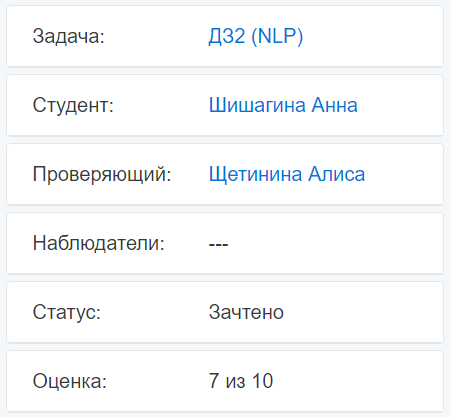